In [2]:
import os
import glob

import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader

from tqdm.auto import tqdm

from transformers import (
    Wav2Vec2ProcessorWithLM, 
    Wav2Vec2Processor, 
    AutoFeatureExtractor,
    Wav2Vec2ForCTC,
)

from datasets import load_dataset, load_metric, Audio

# Self-training for ASR with HuggingFace

In [3]:
import torch

from dataclasses import dataclass, field
from typing import Any, Dict, List, Optional, Union

@dataclass
class DataCollatorCTCWithPadding:
    """
    Data collator that will dynamically pad the inputs received.
    Args:
        processor (:class:`~transformers.Wav2Vec2Processor`)
            The processor used for proccessing the data.
        padding (:obj:`bool`, :obj:`str` or :class:`~transformers.tokenization_utils_base.PaddingStrategy`, `optional`, defaults to :obj:`True`):
            Select a strategy to pad the returned sequences (according to the model's padding side and padding index)
            among:
            * :obj:`True` or :obj:`'longest'`: Pad to the longest sequence in the batch (or no padding if only a single
              sequence if provided).
            * :obj:`'max_length'`: Pad to a maximum length specified with the argument :obj:`max_length` or to the
              maximum acceptable input length for the model if that argument is not provided.
            * :obj:`False` or :obj:`'do_not_pad'` (default): No padding (i.e., can output a batch with sequences of
              different lengths).
    """

    processor: Wav2Vec2Processor
    padding: Union[bool, str] = True

    def __call__(self, features: List[Dict[str, Union[List[int], torch.Tensor]]]) -> Dict[str, torch.Tensor]:
        # split inputs and labels since they have to be of different lenghts and need
        # different padding methods
        input_features = [{"input_values": feature["input_values"]} for feature in features]
        

        batch = self.processor.pad(
            input_features,
            padding=self.padding,
            return_tensors="pt",
        )
        
        if "labels" in features[0].keys():
            label_features = [{"input_ids": feature["labels"]} for feature in features]
            with self.processor.as_target_processor():
                labels_batch = self.processor.pad(
                    label_features,
                    padding=self.padding,
                    return_tensors="pt",
                )

            # replace padding with -100 to ignore loss correctly
            labels = labels_batch["input_ids"].masked_fill(labels_batch.attention_mask.ne(1), -100)

            batch["labels"] = labels

        return batch

## Scores for filtering

In [1]:
model_dir = "arampacha/wav2vec2-xls-r-1b-hy-cv"

In [4]:
processor = Wav2Vec2ProcessorWithLM.from_pretrained(model_dir)

data_collator = DataCollatorCTCWithPadding(processor=processor, padding=True)

Downloading:   0%|          | 0.00/260 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/343 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/415 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/23.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/695 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/453 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/880M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/78.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/10.1M [00:00<?, ?B/s]

In [5]:
@torch.no_grad()
def predict(model, dataset, bs=32, device="cpu"):
    model.eval()
    model.to(device)
    loader = DataLoader(
        dataset, batch_size=bs, collate_fn=data_collator, shuffle=False, drop_last=False, num_workers=4
    )
    all_logits = []
    for batch in tqdm(loader):
        batch = {k:v.to(device) for k,v in batch.items()}
        logits = model(**batch).logits.cpu()
        all_logits.append(logits)
    lens = [logits.shape[1] for logits in all_logits]
    max_len = max(lens)
    all_logits = [F.pad(logits, (0, 0, 0, max_len-l), value=-100.) for logits, l in zip(all_logits, lens)]
    return torch.cat(all_logits)

In [6]:
device = torch.device("cpu")

In [7]:
model = Wav2Vec2ForCTC.from_pretrained(model_dir)
model.to(device);
model.eval();

Downloading:   0%|          | 0.00/1.99k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/3.59G [00:00<?, ?B/s]

In [8]:
lang_id = "hy-AM"

In [9]:
common_voice_train = load_dataset("mozilla-foundation/common_voice_8_0", lang_id, split="train+validation", use_auth_token=True)
common_voice_test = load_dataset("mozilla-foundation/common_voice_8_0", lang_id, split="test", use_auth_token=True)
common_voice_train = common_voice_train.remove_columns(["accent", "age", "gender", "client_id", "down_votes", "locale", "segment", "up_votes"])
common_voice_test = common_voice_test.remove_columns(["accent", "age", "gender", "client_id", "down_votes", "locale", "segment", "up_votes"])
common_voice_train = common_voice_train.cast_column("audio", Audio(sampling_rate=16_000))
common_voice_test = common_voice_test.cast_column("audio", Audio(sampling_rate=16_000))

Reusing dataset common_voice (/workspace/cache/hf/datasets/mozilla-foundation___common_voice/hy-AM/8.0.0/b8bc4d453193c06a43269b46cd87f075c70f152ac963b7f28f7a2760c45ec3e8)
Reusing dataset common_voice (/workspace/cache/hf/datasets/mozilla-foundation___common_voice/hy-AM/8.0.0/b8bc4d453193c06a43269b46cd87f075c70f152ac963b7f28f7a2760c45ec3e8)


In [10]:
import re
chars_to_remove_regex = re.compile("[^\sաբգդեզէըթժիլխծկհձղճմյնշոչպջռսվտրցւփքօֆև]")
# chars_to_remove_regex = re.compile("[^\sაბგდევზთიკლმნოპჟრსტუფქღყშჩცძწჭხჯჰ]")

def normalize_text(batch):
    text = re.sub(chars_to_remove_regex, '', batch["sentence"].lower())
    batch["sentence"] = " ".join(text.split())
    return batch

In [11]:
common_voice_train = common_voice_train.map(normalize_text)
common_voice_test = common_voice_test.map(normalize_text)

0ex [00:00, ?ex/s]

0ex [00:00, ?ex/s]

In [12]:
test_transcripts = common_voice_test["sentence"]
test_transcripts[:5]

['վատիկանի թանգարանները համարվում են աշխարհում ամենամեծ թանգարաններից մեկը',
 'լոյանը չինական հնագույն բնակավայրերից է',
 'կան նաև սանրեր կենդանիների բրդի համար',
 'այդպես կայացել է նրանց ծանոթությունը',
 'որոշումը ենթարկվել է քննադատության']

In [13]:
def prepare_dataset(batch):
    audio = batch["audio"]

    # batched output is "un-batched"
    batch["input_values"] = processor(audio["array"], sampling_rate=audio["sampling_rate"]).input_values[0]
    batch["input_length"] = len(batch["input_values"])
    
    with processor.as_target_processor():
        batch["labels"] = processor(batch["sentence"]).input_ids
    return batch

In [14]:
common_voice_test = common_voice_test.map(prepare_dataset, remove_columns=common_voice_test.column_names)

0ex [00:00, ?ex/s]

In [17]:
logits = predict(model, common_voice_test, device=device).numpy()

  0%|          | 0/43 [00:00<?, ?it/s]

In [18]:
wer_metric = load_metric("wer")
cer_metric = load_metric("cer")

In [ ]:
lm_params = {"alpha":0.5, "beta":1.5}
best_wer = 1.

print(f"alpha\t| beta\t| wer\t\t| cer")
for alpha in [0.5, 0.6, 0.7, 0.8]:
    for beta in [1.5, 2., 2.5, 3.,]:
        processor.decoder.reset_params(alpha=alpha, beta=beta)
        decoded_preds = processor.batch_decode(logits, beam_width=100, num_processes=8)
        wer = wer_metric.compute(predictions=decoded_preds.text, references=test_transcripts)
        cer = cer_metric.compute(predictions=decoded_preds.text, references=test_transcripts)
        if wer < best_wer:
            lm_params["alpha"] = alpha
            lm_params["beta"] = beta
            best_wer = wer
        print(f"{alpha}\t| {beta}\t| {wer:.4f}\t| {cer:.4f}")
        
print("\nBest LM parameters: ", lm_params)

In [21]:
processor.decoder.reset_params(**lm_params)
decoded_preds = processor.batch_decode(logits, beam_width=100, num_processes=8)

In [ ]:
import random

ids = random.sample(range(len(common_voice_test)), k=5)
for i in ids:
    print(decoded_preds.logit_score[i], decoded_preds.lm_score[i])
    print(decoded_preds.text[i])
    print(test_transcripts[i])

In [23]:
text_length = np.array([len(s) for s in decoded_preds.text])
lm_scores = np.array(decoded_preds.lm_score)

In [24]:
wer_metric.compute(predictions=decoded_preds.text, references=test_transcripts)

0.08497450764770569

In [25]:
cer_metric.compute(predictions=decoded_preds.text, references=test_transcripts)

0.013403284343670272

In [26]:
example_wer = np.array([wer_metric.compute(predictions=[pred], references=[ref]) for pred, ref in zip(decoded_preds.text, test_transcripts)])
example_wer.mean()

0.09012453676022449

In [27]:
from sklearn.linear_model import LinearRegression

reg = LinearRegression()
reg.fit(np.expand_dims(np.array(text_length), axis=1), np.array(decoded_preds.lm_score))

a = reg.coef_[0]
b = reg.intercept_
print(f"{a:.7f}, {b:.7f}")

-0.4546830, -6.5747010


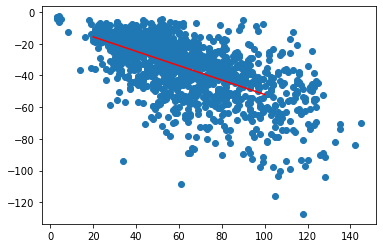

In [28]:
fig, ax = plt.subplots()
ax.scatter(text_length, decoded_preds.lm_score)
x = np.array([20, 100])
ax.plot(x, a*x+b, "r")
plt.show()

In [29]:
scores = (lm_scores - a*text_length - b)/ np.sqrt(text_length)
std = scores.std()
print(std)

1.886743129679298


In [30]:
scores  = scores/ scores.std()

In [31]:
mask = scores > 1.

print(f"Selected {mask.sum()}/{len(mask)} examples after filtering with average WER {example_wer[mask].mean()}")

Selected 159/1345 examples after filtering with average WER 0.02480136914099178


## VoxLingua107 data

In [32]:
unsup_dataset = load_dataset("/workspace/data/scripts/voxlingua107.py", lang_id, split="train")
len(unsup_dataset)

Reusing dataset vox_lingua107 (/workspace/cache/hf/datasets/vox_lingua107/ka/0.0.0/d383a2e2e96888e080f3c30c8f149f4b088038234652926d1276730b951c2f0c)


35199

In [33]:
from datasets import load_dataset, Dataset, Audio, load_from_disk

In [34]:
sampling_rate = 16_000
unsup_dataset = unsup_dataset.cast_column("audio", Audio(sampling_rate))

In [36]:
unsup_dataset[0]

{'path': '/workspace/cache/hf/datasets/downloads/extracted/c12dcae4ca564c99f8e6292bf6003140baef8d736f9a55f54e896553ec3dc555/ka/C42t8WqHOwc__U__S126---0802.300-0809.210.wav',
 'audio': {'path': '/workspace/cache/hf/datasets/downloads/extracted/c12dcae4ca564c99f8e6292bf6003140baef8d736f9a55f54e896553ec3dc555/ka/C42t8WqHOwc__U__S126---0802.300-0809.210.wav',
  'array': array([ 0.00366211,  0.00408936,  0.00671387, ..., -0.02984619,
         -0.03057861, -0.03488159]),
  'sampling_rate': 16000}}

In [37]:
unsup_dataset = unsup_dataset.map(lambda s: {"duration": len(s["audio"]["array"]) / sampling_rate})

Loading cached processed dataset at /workspace/cache/hf/datasets/vox_lingua107/ka/0.0.0/d383a2e2e96888e080f3c30c8f149f4b088038234652926d1276730b951c2f0c/cache-09fb432e103e8e70.arrow


In [38]:
durs = np.array(unsup_dataset["duration"])

durs.mean(), durs.std(), durs.min(), durs.max()

(9.997589961717663, 4.79124008921328, 1.84, 20.0)

In [39]:
filtered_dataset = unsup_dataset.filter(lambda x: (3. < x < 16.), input_columns="duration")
len(filtered_dataset)

  0%|          | 0/36 [00:00<?, ?ba/s]

29200

In [40]:
filtered_dataset = filtered_dataset.sort("duration")

In [27]:
# filtered_ds = load_from_disk("/workspace/data/hy/tmp/filtered_ds")

In [41]:
durs = np.array(filtered_dataset["duration"])

durs.mean(), durs.std(), durs.min(), durs.max()

(8.690454758133562, 3.601254919607131, 3.01, 15.9999375)

In [20]:
from transformers import Wav2Vec2ProcessorWithLM

# processor = Wav2Vec2ProcessorWithLM.from_pretrained(model_dir)

In [42]:
def preprocess(batch):
    audio = batch["audio"]
    
    batch["input_values"] = processor(audio["array"], sampling_rate=audio["sampling_rate"]).input_values[0]
    # batch["length"] = len(batch["input_values"])
    return batch

In [43]:
processed_dataset = filtered_dataset.map(preprocess, remove_columns=filtered_dataset.column_names, num_proc=4)

## VoxLingua inference

In [ ]:
vl_logits = predict(model, processed_dataset, device="cuda", bs=64).numpy()

  0%|          | 0/457 [00:00<?, ?it/s]

In [ ]:
np.save("voxlingua_hy_logits_1.npy", vl_logits)

In [11]:
vl_logits = np.load("voxlingua_hy_logits_1.npy")

In [56]:
vl_logits.shape

(29200, 799, 38)

In [ ]:
vl_decoded_preds = processor.batch_decode(vl_logits, beam_width=100, num_processes=8)

In [ ]:
vl_decoded_preds.text[:10]

In [ ]:
vl_decoded_preds.lm_score[:10]

In [ ]:
text_length = np.array([len(s) for s in vl_decoded_preds.text])
lm_scores = np.array(vl_decoded_preds.lm_score)

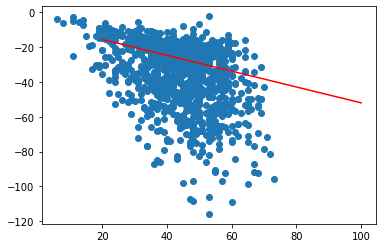

In [57]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
ax.scatter(text_length[:1000], lm_scores[:1000])
x = np.array([20, 100])
ax.plot(x, a*x+b, "r")

In [ ]:
vl_scores = (lm_scores - a*text_length - b)/ np.sqrt(text_length) / std

In [64]:
mask = vl_scores > .1

print(f"Selected {mask.sum()}/{len(mask)} examples after filtering")

Selected 4992/29200 examples after filtering


In [65]:
len(common_voice_train)

3003

In [ ]:
idx = np.arange(len(mask))[mask]
print("lm_score\t|adj_score\t| text")
print("-"*100)
for i, _ in zip(idx, range(10)):
    
    print(f"{lm_scores[i]:.2f}\t\t|{vl_scores[i]:.2f}\t\t|", vl_decoded_preds.text[i])

In [67]:
labeled_dataset = filtered_dataset.select(idx)

In [68]:
paths = labeled_dataset["path"]
type(paths), len(paths)

(list, 4992)

In [69]:
from datasets import Dataset, DatasetDict

labeled_dataset = Dataset.from_dict({"path":paths, "audio":paths, "sentence":[vl_decoded_preds.text[i] for i in idx]})

In [70]:
labeled_dataset = labeled_dataset.cast_column("audio", Audio(sampling_rate))

In [71]:
labeled_dataset.save_to_disk("/workspace/data/ka/vox_lingua_ka_labeled_2")

In [77]:
from datasets import interleave_datasets, concatenate_datasets, DatasetDict, load_from_disk

In [73]:
len(labeled_dataset)

4992

In [74]:
common_voice_train = load_dataset("mozilla-foundation/common_voice_8_0", lang_id, split="train+validation", use_auth_token=True)
common_voice_test = load_dataset("mozilla-foundation/common_voice_8_0", lang_id, split="test", use_auth_token=True)
common_voice_train = common_voice_train.remove_columns(["accent", "age", "gender", "client_id", "down_votes", "locale", "segment", "up_votes"])
common_voice_test = common_voice_test.remove_columns(["accent", "age", "gender", "client_id", "down_votes", "locale", "segment", "up_votes"])
common_voice_train = common_voice_train.cast_column("audio", Audio(sampling_rate=16_000))
common_voice_test = common_voice_test.cast_column("audio", Audio(sampling_rate=16_000))
common_voice_train = common_voice_train.map(normalize_text)
common_voice_test = common_voice_test.map(normalize_text)

Reusing dataset common_voice (/workspace/cache/hf/datasets/mozilla-foundation___common_voice/ka/8.0.0/b8bc4d453193c06a43269b46cd87f075c70f152ac963b7f28f7a2760c45ec3e8)
Reusing dataset common_voice (/workspace/cache/hf/datasets/mozilla-foundation___common_voice/ka/8.0.0/b8bc4d453193c06a43269b46cd87f075c70f152ac963b7f28f7a2760c45ec3e8)
Loading cached processed dataset at /workspace/cache/hf/datasets/mozilla-foundation___common_voice/ka/8.0.0/b8bc4d453193c06a43269b46cd87f075c70f152ac963b7f28f7a2760c45ec3e8/cache-a2137eb2f9b14668.arrow
Loading cached processed dataset at /workspace/cache/hf/datasets/mozilla-foundation___common_voice/ka/8.0.0/b8bc4d453193c06a43269b46cd87f075c70f152ac963b7f28f7a2760c45ec3e8/cache-9a716bcb312f31ef.arrow


In [75]:
probs = np.array([len(common_voice_train), len(labeled_dataset)]) / (len(common_voice_train) + len(labeled_dataset))
probs

array([0.37560976, 0.62439024])

In [78]:
# train_dataset = interleave_datasets([common_voice_train, labeled_dataset], probabilities=probs)
train_dataset = concatenate_datasets([common_voice_train, labeled_dataset])

In [79]:
len(train_dataset)

7995

In [80]:
noizy_student_ds = DatasetDict({"train":train_dataset, "test":common_voice_test})

In [81]:
noizy_student_ds.save_to_disk("/workspace/data/hy/noizy_student_1")

In [76]:
import IPython.display as ipd
import numpy as np
import random

i = int(random.choice(idx))

print(vl_decoded_preds.text[i])
print(f"lm_score {lm_scores[i]:.2f}| score {vl_scores[i]:.2f}")
ipd.Audio(data=filtered_ds[i]["audio"]["array"], autoplay=True, rate=16000)

այսպիսով արարատյան դաշտավայրի ջուրի հարցը դարձել է ազգային խնդիր
lm_score -28.41| score 0.22
